# Qualitative Evaluation for the VAE model

In [5]:
import torch
import torchgadgets as tg
import os
from pathlib import Path as P
import numpy as np
import utils
from models import ConvVAE
from tbparse import SummaryReader
from matplotlib.gridspec import GridSpec 

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score




import matplotlib.pyplot as plt

from torchsummary import summary


## Model Information

In [6]:
exp_name = 'vae_test'
run_name = 'test_2'
checkpoint = 10

log_dir = P(os.getcwd(), 'experiments', exp_name, run_name, 'logs')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Model/Data Loading

In [8]:
# Load the config files
load_augm_config_train = utils.load_config('augm_train_preLoad') 
load_augm_config_test = utils.load_config('augm_test_preLoad')

config = utils.load_config_from_run(exp_name, run_name)
config['num_iterations'] = config['dataset']['train_size'] // config['batch_size']

tg.tools.set_random_seed(config['random_seed'])
##-- Load Dataset --##
# Simply load the dataset using TorchGadgets and define our dataset to apply the initial augmentations
data = tg.data.load_dataset('food101')
train_dataset = data['train_dataset']
test_dataset = data['test_dataset']
train_dataset = tg.data.ImageDataset(dataset=train_dataset, transforms=load_augm_config_train)
test_dataset = tg.data.ImageDataset(dataset=test_dataset, transforms=load_augm_config_test, train_set=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True, num_workers=2)

##-- Load Model from Checkpoint --##
model = ConvVAE(input_size=(3,224,224), encoder_layers=config['encoder_layers'], decoder_layers=config['decoder_layers'], latent_dim=config['latent_dim'])
utils.load_model_from_checkpoint(exp_name, run_name, model, checkpoint)

##-- Data Augmentor --##
data_augmentor = tg.data.ImageDataAugmentor(config=config['pre_processing'])

##-- Load TensorBoard Logs --##
reader = SummaryReader(log_dir, pivot=True)
train_data = reader.scalars

train_loss = train_data.loc[:,'iteration_metrics/train_loss'].to_numpy().tolist()
train_mse= train_data.loc[:,'iteration_metrics/mse'].to_numpy().tolist()
train_kld = train_data.loc[:,'iteration_metrics/kld'].to_numpy().tolist()

eval_loss = train_data.loc[:,'epoch_metrics/eval_loss'].to_numpy().tolist()
eval_mse= train_data.loc[:,'epoch_metrics/mse'].to_numpy().tolist()
eval_kld = train_data.loc[:,'epoch_metrics/kld'].to_numpy().tolist()

categories = [
    'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare',
    'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito',
    'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake',
    'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla',
    'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder',
    'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes',
    'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict',
    'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras',
    'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari',
    'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad',
    'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza',
    'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus',
    'ice_cream', 'lasagna',
    'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese',
    'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings',
    'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck',
    'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich',
    'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi',
    'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese',
    'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake',
    'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles'
]

Model checkpoint was load from: /home/user/denninge/VisionLabSS23/Assignments_6/experiments/vae_test/test_2/checkpoints/checkpoint_10.pth


## Model Architecture

In [9]:
print(model)
summary(model.to('cuda'), (3,224,224))

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): GELU(approximate='none')
    (11): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1

## Training Progress

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (15,) + inhomogeneous part.

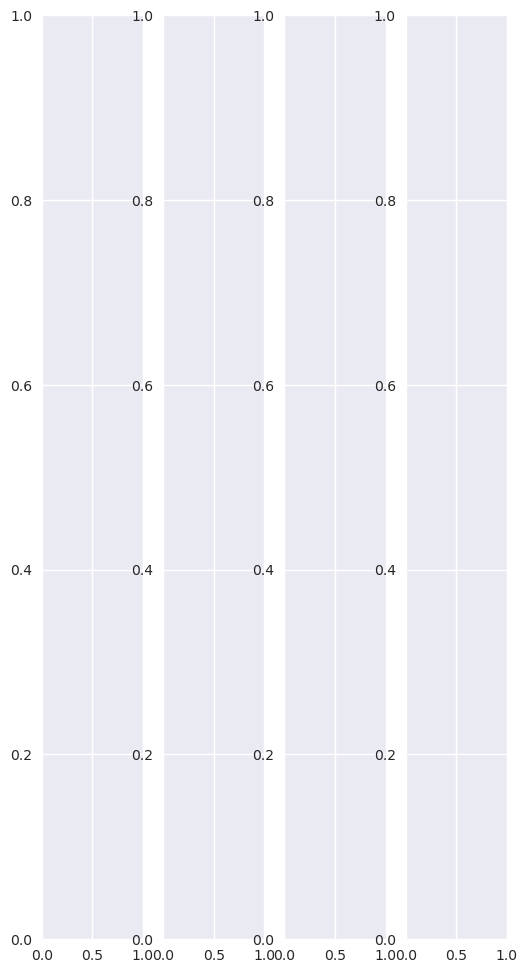

In [11]:
plt.style.use('seaborn-v0_8')

x_ticks_pos = np.arange(0, config['num_iterations']*(config['num_epochs']+1), config['num_iterations'])
x_ticks = np.arange(0,config['num_epochs']+1)

fig, ax = plt.subplots(1,4, figsize=(12,6))

smooth_loss = tg.visualization.smooth_curve(train_loss, K=31)
smooth_mse = tg.visualization.smooth_curve(train_mse, K=31)
smooth_kld = tg.visualization.smooth_curve(train_kld, K=31)

ax[0].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].set_xticks(x_ticks_pos, x_ticks)
ax[0].legend(loc="best")
ax[0].set_xlabel("# Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Loss")

ax[1].plot(smooth_loss, c="red", label="Combined Loss", linewidth=2, alpha=1)
ax[1].plot(smooth_mse, c="blue", label="MSE", linewidth=2, alpha=1)
ax[1].plot(smooth_kld, c="green", label="KL-Divergence", linewidth=2, alpha=1)
ax[1].set_xticks(x_ticks_pos, x_ticks)
ax[1].legend(loc="best")
ax[1].set_xlabel("# Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].set_title("Independent Losses")

ax[2].plot(eval_loss, c="red", label="Combined Loss", linewidth=2, alpha=1)
ax[2].plot(eval_mse, c="blue", label="MSE", linewidth=2, alpha=1)
ax[2].plot(eval_kld, c="green", label="KL-Divergence", linewidth=2, alpha=1)
ax[2].set_xticks(x_ticks)
ax[2].legend(loc="best")
ax[2].set_xlabel("# Epoch")
ax[2].set_ylabel("Loss")
ax[2].set_yscale("log")
ax[2].set_title("Evaluation Loss")

ax[3].plot(train_loss, c="red", label="Train Loss", linewidth=2, alpha=1)
ax[3].plot(eval_loss, c="green", label="Evaluation Loss", linewidth=2, alpha=1)
ax[3].set_xticks(x_ticks_pos, x_ticks)
ax[3].legend(loc="best")
ax[3].set_xlabel("# Epoch")
ax[3].set_ylabel("Loss")
ax[3].set_yscale("log")
ax[3].set_title("Training/Evaluation Losses")


# Evaluation RUn

In [ ]:
model = model.to(device)
eval_imgs, eval_output, eval_latents, eval_labels = [], [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        output, (z, mu, sigma) = model(imgs)
        eval_imgs.append(imgs.cpu())
        eval_output.append(output.cpu())
        eval_latents.append(z.cpu())
        eval_labels.append(lbls)

model = model.to('cpu')

## Reconstruction Samples

In [ ]:
img, output, label = eval_imgs[0], eval_labels[0]


# Visualize images and their reconstruction
layout = (4,5)
num_imgs = layout[0]*layout[1]
fig = plt.figure(figsize=(30,15))

figure_grid = GridSpec(layout[0], layout[1], figure=fig)

img_ind = 0
for x in range(layout[0]):
    for y in range(layout[1]):
        img_plot = figure_grid[x,y].subgridspec(1,2, wspace=0.1, hspace=0.0)
        ax = fig.add_subplot(img_plot[0])
        ax.imshow(img[img_ind])
        ax.axis('off')
        ax.set_title('Original')
        ax = fig.add_subplot(img_plot[1])
        ax.imshow(output[img_ind])
        ax.axis('off')
        ax.set_title('Reconstructed')

fig.show()

## Analysis of the Latent Space

### Visualization Latent Space

In [ ]:
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)])
    ax.legend(loc="best")

In [ ]:
# Parameters
num_display = 2000

imgs_flat = np.concatenate([img.view(imgs.shape[0],-1) for img in eval_imgs])
latents_np = np.concatenate(eval_latents)
labels_np = np.concatenate(eval_labels)

pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)

# N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:num_display], labels_np[:num_display], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(latents_np[:num_display], labels_np[:num_display], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("Encoded Representations")
plt.show()

In [ ]:
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents_np[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:num_display], labels_np[:num_display], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:num_display], labels_np[:num_display], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()



### Interpolation over Latent Space

In [ ]:

@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    SIZE = 32
    grid = np.empty((N*SIZE, N*SIZE))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z).cpu()
            x_hat = x_hat.view(32,32)
            
            grid[(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat
           
    plt.figure(figsize=(12,20))
    plt.imshow(grid, extent=[*yrange, *xrange], cmap="gray")
    plt.axis("off")


In [ ]:
plot_reconstructed(model, xrange=(-2, 2), yrange=(-2, 2), N=20)